In [1]:
import os
import requests
import pandas as pd
import time
import datetime
from pathlib import Path
from panel.interact import interact
import plotly.express as px
import panel as pn

In [6]:
# Read history from csv
history_data = Path("data/data_5year.csv")
history_df = pd.read_csv(history_data, index_col="Date", parse_dates=True, infer_datetime_format=True)

# clean unused column from dataframe
if 'Unnamed: 0' in history_df.columns:
    history_df = history_df.drop(['Unnamed: 0'], axis=1)

In [7]:
history.head()

,Ticker,Price,Market Caps,Total Volumes
Date,,,,
2015-01-02,bitcoin,314.4460,4.301448e+09,3.885591e+07
2015-01-03,bitcoin,286.5720,3.921358e+09,1.187789e+08
2015-01-04,bitcoin,260.9360,3.571640e+09,2.055001e+08
2015-01-05,bitcoin,273.2200,3.740880e+09,1.550381e+08
2015-01-06,bitcoin,285.3738,3.908408e+09,9.700290e+07


In [19]:
def price_by_security_dataframe(history_df, ticker, ticker_header, price_header):
    
    # Slice history_df to only specified ticker, sort dates in descending order, select only prices column, perform percent change and drop NA
    daily_returns = history[history[ticker_header] == ticker].sort_index(ascending=False).loc[:, [price_header]].pct_change().dropna()
    
    # Rename column to "Daily Returns"
    daily_returns = daily_returns.rename(columns={ daily_returns.columns[0]: "Daily Returns" })
    
    # Return daily_returns
    return daily_returns

def cumulative_returns_dataframe(history_df, ticker, ticker_header, price_header):
    
    # Get daily returns
    daily_returns = price_by_security_dataframe(history_df = history_df, ticker = ticker, ticker_header = ticker_header, price_header = price_header)
    
    # Calculate cumulative returns
    cumulative_returns = (1 + daily_returns).cumprod()
    
    # Rename column to "Cumulative Returns"
    cumulative_returns = cumulative_returns.rename(columns={ cumulative_returns.columns[0]: "Cumulative Returns" })
    
    return cumulative_returns

def cumulative_returns_plot(history_df, ticker, ticker_header=None, price_header=None):

    # Set return value as None
    plt = None
    
    try:
        
        # Test if ticker_header suppied exists, and looks for a default header if not
        
        if not ticker_header in list(history_df.columns):
            if "Ticker" in list(history_df.columns):
                ticker_header = "Ticker"
            elif "ticker" in list(history_df.columns):
                ticker_header = "ticker"
            else:
                 raise ValueError("No ticker column found")
    
        if not price_header in list(history_df.columns):
            if "Price" in list(history_df.columns):
                price_header = "Price"
            elif "price" in list(history_df.columns):
                price_header = "price"
            else:
                raise ValueError("No price column found")
                
        # test if valid ticker is supplied
        
        if not ticker in list(history_df[ticker_header].unique()):
            raise ValueError("Ticker does not exist in dataframe")
            
        # get cumulative returns
        df = cumulative_returns_dataframe(history_df = history_df, ticker = ticker, ticker_header = ticker_header, price_header = price_header)

        # use plotly
        plt = px.line(df, labels=dict(x="Date", y="Cumulative Returns", color="Cumulative Returns")) 
        
        plt.update_xaxes(title_text='Date')
        plt.update_yaxes(title_text='Cumulative Returns')
        
    except ValueError as err:
        print('Value error: ', err)
    
    return plt


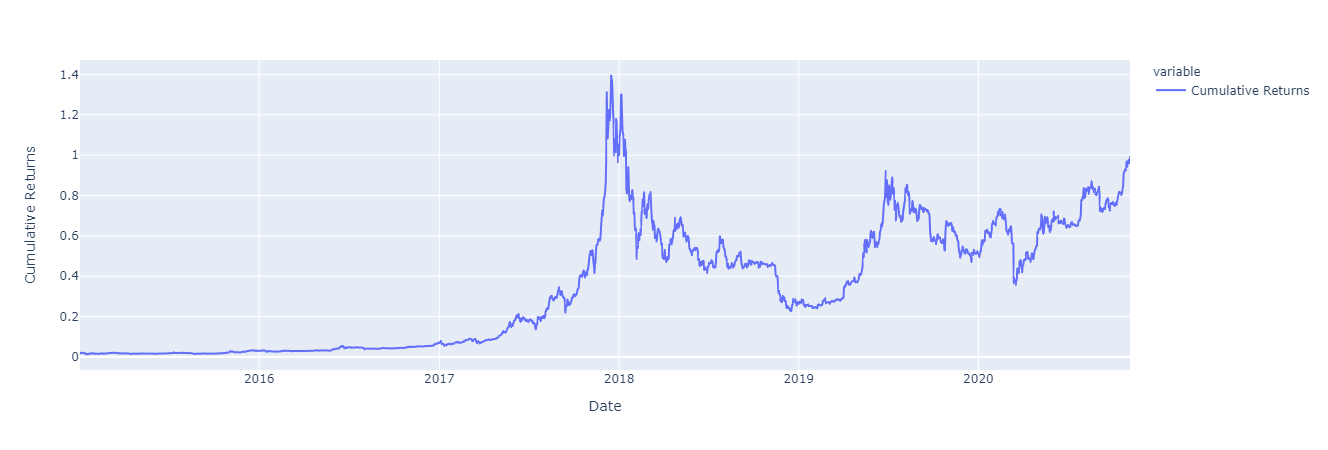

In [20]:
# df = cumulative_returns_dataframe(history_df=history_df, ticker='bitcoin', ticker_header="Ticker", price_header="Price")
# df
cumulative_returns_plot(history_df=history_df, ticker='bitcoin')